# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sn

# Choose options
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True

In [2]:
PROCESS_IMAGES = True
PROCESS_DATA = True

# List images

In [3]:
path = os.getcwd()
os.chdir(path)
sys.path.append(path)
sys.path.append(os.path.join(path, 'scripts'))

path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    x_col = mix.pop('x')
    y_col = mix.pop('y')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    orientation_col = mix.pop('orientation')
    center_dist_col = mix.pop('center distance')
    mix.insert(12, 'weight', weight_col)
    mix.insert(13, 'x', x_col)
    mix.insert(14, 'y', y_col)
    mix.insert(15, 'centroid_x', centroid_x_col)
    mix.insert(16, 'centroid_y', centroid_y_col)
    mix.insert(17, 'center distance', center_dist_col)
    mix.insert(18, 'orientation', orientation_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

Generated data


,area,x,y,width,height,MA,ma,centroid_x,centroid_y,orientation,% area,center distance,eccentricity,perimeter,symmetry
uuid,,,,,,,,,,,,,,,
0018b76693a14e20bce3027ff67dc055,273025.289744,196,119,576,346,563.124084,304.146881,256.936205,474.006991,-1.354229,37.094907,52.797104,0.841597,1727.474300,0.258794
00607e166c6e4054ab75451aacfbe32d,265083.619523,186,118,592,339,574.335022,307.100464,256.117320,475.959981,-1.411931,37.175204,54.402276,0.845038,1757.658066,0.264058
00635ae09a834ebf86ee85c58c12ff82,201016.798552,109,108,565,245,523.746887,250.569244,236.973260,406.623991,-1.546777,26.957412,17.637654,0.878133,1552.628628,0.170682
0066778f47734ca7a71be790f562c551,271063.185330,195,120,578,344,563.428528,306.356812,257.628463,474.442444,-1.371848,37.232194,53.434099,0.839256,1733.131154,0.262357
006d8cf500f14647a8de9ecf71951066,194461.430407,203,77,441,359,504.326263,214.100098,249.227366,400.285640,-1.013740,34.536056,25.446319,0.905415,1436.261097,0.274467


Loaded data


,uuid,id,sex,weight
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,24.5
1,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1
2,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5
3,3c4dcc3c6d83425dab0d0acd75227f99,0236,0,25.5
4,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8


Final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,31.556203,0.923067,1797.356550,0.278912,24.5,103,105,289.106442,390.449962,59.473084,-1.311328
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,33.337513,0.947797,1741.817446,0.325646,27.1,80,202,326.109352,426.348274,86.141366,1.442194
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,27.056971,0.968554,1568.812394,0.269251,25.5,195,103,269.857033,490.162297,72.587133,1.181906
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,27.938418,0.955026,1589.508790,0.367365,25.8,117,181,286.499335,443.777858,50.530701,1.524029
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,34.304833,0.938257,1437.391040,0.361053,25.5,171,96,295.144955,422.247464,55.172797,-1.090923


# Process data

Load final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,31.556203,0.923067,1797.356550,0.278912,24.5,103,105,289.106442,390.449962,59.473084,-1.311328
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,33.337513,0.947797,1741.817446,0.325646,27.1,80,202,326.109352,426.348274,86.141366,1.442194
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,27.056971,0.968554,1568.812394,0.269251,25.5,195,103,269.857033,490.162297,72.587133,1.181906
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,27.938418,0.955026,1589.508790,0.367365,25.8,117,181,286.499335,443.777858,50.530701,1.524029
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,34.304833,0.938257,1437.391040,0.361053,25.5,171,96,295.144955,422.247464,55.172797,-1.090923


1862 images loaded
X data


,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry
1164,1,207509.855532,559,295,542.772461,246.663971,31.495230,0.890771,1746.268237,0.277396
360,1,201739.491677,452,339,447.979065,307.376648,44.262654,0.727469,1622.770764,0.515178
1780,1,193598.136845,634,343,717.793762,197.792206,29.831427,0.961285,1791.616436,0.300733
624,1,197838.292177,637,338,717.470337,197.119812,29.585786,0.961518,1794.545368,0.297729
269,0,240581.831417,640,311,641.193787,247.990921,30.604655,0.922179,1941.481440,0.195395


y data


,weight
1164,20.2
360,16.1
1780,16.0
624,16.0
269,18.9


Correlation matrix


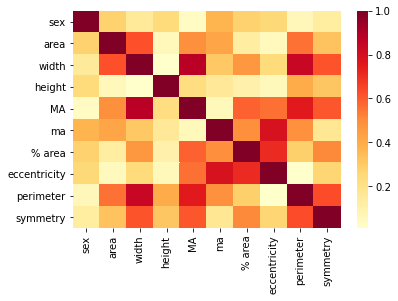

In [6]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
print("Load final data")
display(file_data.head())
#file_data = file_data[file_data['symmetry']>0.65]
#file_data = file_data[file_data['area']>200000]
#file_data = file_data[file_data['% area']>0.5]
file_data = shuffle(file_data)

print(len(file_data),"images loaded")

X = file_data.loc[:, 'sex':'symmetry']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[decisionTree], 'classifier__criterion':['mse', 'friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      #cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
else:
    #Load last model
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']

In [7]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
resultados.head()
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 
                             'mean_test_neg_root_mean_squared_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 'mean_test_neg_mean_absolute_error',
                         'mean_test_neg_root_mean_squared_error', 'std_test_r2', 'std_test_explained_variance', 'std_test_max_error', 'std_test_neg_mean_absolute_error',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_r2', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo).round(4)

Best model: DecisionTreeRegressor(criterion='mae', max_features='auto')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_explained_variance,std_test_max_error,std_test_neg_mean_absolute_error
param_classifier,,,,,,,,,
DecisionTreeRegressor,0.9408,0.9412,-8.7600,-0.2587,-1.1477,0.0519,0.0511,2.4596,0.1022
LassoLarsCV,0.6541,0.6558,-10.0174,-2.0458,-2.7953,0.0288,0.0289,2.0758,0.0844
LassoCV,0.6539,0.6556,-9.4875,-2.0755,-2.7961,0.0275,0.0280,2.0724,0.0778
RidgeCV,0.6538,0.6555,-9.7888,-2.0592,-2.7970,0.0259,0.0264,1.8155,0.0821
LinearRegression,0.6537,0.6553,-10.1637,-2.0458,-2.7968,0.0288,0.0290,2.1937,0.0844
Ridge,0.6497,0.6515,-8.9935,-2.1018,-2.8148,0.0217,0.0223,0.8982,0.0744
Lasso,0.4137,0.4492,-8.2274,-2.8483,-3.6391,0.1633,0.0550,3.3041,0.2149
LassoLars,0.4133,0.4489,-8.7517,-2.8490,-3.6402,0.1633,0.0546,3.2987,0.2146


In [8]:
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained vairance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

R2 score: 0.9346891329705731
Explained vairance score: 0.9347042163954257
Max error: 11.7
Mean absolute error: 0.25545617173524154


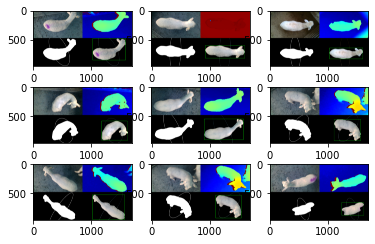

In [9]:
files = []
differences = []
for i in range(0,len(best_estimator_predictions)):
    difference = abs(best_estimator_predictions[i]-y_test.iloc[i].weight) 
    if difference>2:
        uuid = file_data.loc[y_test.iloc[i].name].uuid
        files.append(uuid)
        differences.append(difference)
"""
print(differences)
print(dif_total)

file_data_new = file_data[file_data['uuid'].isin(files)]
display(file_data_new)
"""

max_images = 9 if (len(files)>9)  else len(files)
for i in range(0,max_images):
    plt.subplot(3,3,i+1)
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', files[i]+'_mosaico.png'))
    imgplot = plt.imshow(img)

plt.savefig(os.path.join("..", 'data', 'mismatch.jpeg'), bbox_inches='tight')